In [5]:
import scanpy as sc
import numpy as np
import torch
from ndreamer import NDreamer

AnnData object with n_obs × n_vars = 5027 × 773
    obs: 'perturbation', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'leiden', 'cell_type0528', 'condition', 'cell_type1021'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type0528_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
[[-0.11865562 -0.17559336 -0.13184807 -0.15251128 -0.24557106 -0.38421327
  -0.2019245  -0.13745788 -0.23247382 -0.08626232]
 [-0.13325824 -0.20568384 -0.14286487 -0.16371657 -0.2607082  -0.2985558
  -0.20685168 -0.15235388 -0.23922235 -0.10109032]
 [-0.15649903  4.662776   -0.13260117 -0.15959612 -0.27189648  5.3158584
   5.4904327  -0.15063947 -0.20590055 -0.12422334]
 [ 0.02574939  0.06054411  0.07222535  0.03342935 -0.05172267  1.4757854
   0.01838049  0.096

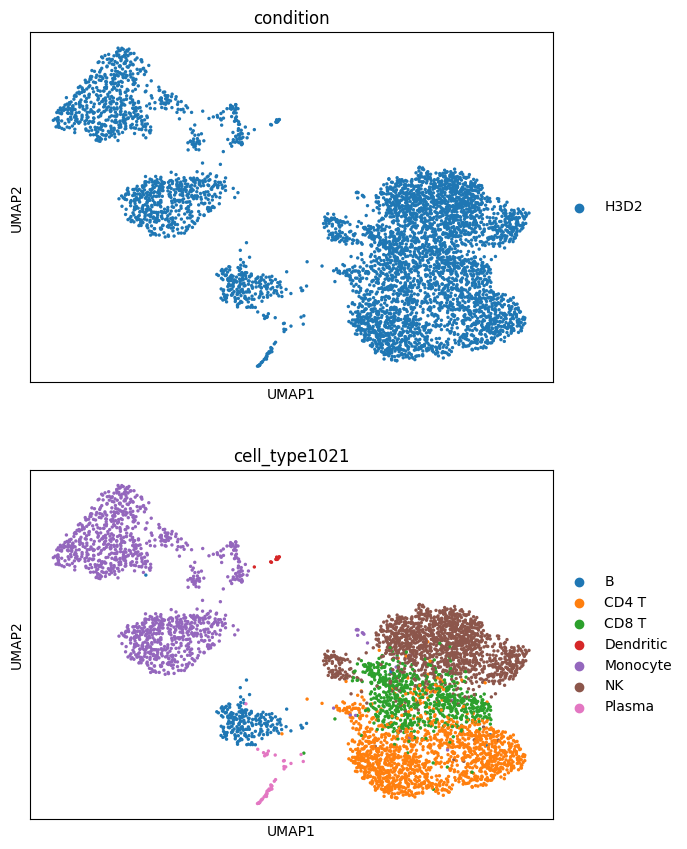

In [6]:
adata_raw = sc.read_h5ad('../data/PBMC_yale_preprocessed.h5ad')
#adata_raw=adata_raw[adata_raw.obs["batch"].isin(['CSE',"MOCK"])].copy()
adata_raw.obs["perturbation"]=adata_raw.obs["batch"].copy()
adata_raw.obs["condition"]=adata_raw.obs["perturbation"].copy()
adata_raw.obs["cell_type1021"]=adata_raw.obs['cell_type0528'].copy()

print(adata_raw)
print(adata_raw.X[:10,:10])

sc.pp.pca(adata_raw)
sc.pp.neighbors(adata_raw)
sc.tl.umap(adata_raw)
sc.pl.umap(adata_raw, color=["condition",'cell_type1021'],ncols=1)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

def plot_distribution_with_binary_zscore(vector, gene_name):
    """
    Plots the distribution of the values in the vector, calculates the z-score
    based on the proportion of values > 0 using CLT, and uses the gene name and z-score
    as the title of the plot.

    Args:
    - vector (numpy.ndarray or list): The input vector of values.
    - gene_name (str): The gene name to include in the title.

    Returns:
    - None: Displays the plot.
    """
    # Convert to numpy array if not already
    vector = np.array(vector)

    # Binary transformation: count the number of values > 0
    count_positive = np.sum(vector > 0)+0.5*np.sum(vector==0)
    n = len(vector)
    proportion_positive = count_positive / n  # Proportion of values > 0

    # Calculate z-score using the CLT
    p_null = 0.5  # Null hypothesis: Proportion of values > 0 is 0.5
    std_error = np.sqrt(p_null * (1 - p_null) / n)
    z_score = (proportion_positive - p_null) / std_error

    # Plot the distribution of the vector
    plt.figure(figsize=(8, 6))
    plt.hist(vector, bins=30, alpha=0.7, edgecolor='k', color='blue')
    plt.axvline(0, color='red', linestyle='--', label='Reference: 0')
    plt.title(f"{gene_name} | Z-score: {z_score:.2f} (Proportion > 0: {proportion_positive:.2f})", fontsize=14)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_distribution(vector, bins=30, kde=True, title="Distribution Plot"):
    """
    Plots the distribution of a vector using a histogram and optionally overlays a KDE fitted line.

    Parameters:
    - vector (array-like): The input data vector.
    - bins (int): Number of bins for the histogram. Default is 30.
    - kde (bool): Whether to add a KDE fitted line. Default is True.
    - title (str): Title for the plot. Default is "Distribution Plot".
    """
    plt.figure(figsize=(8, 6))

    # Plot histogram and optionally the KDE
    sns.histplot(vector, bins=bins, kde=kde, color='blue', stat='density', edgecolor='black')

    # Add titles and labels
    plt.title(title, fontsize=14)
    plt.xlabel("Value", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

def plot_distribution1(vector, bins=30, kde=True, title="Distribution Plot"):
    """
    Plots the distribution of a vector using a histogram and optionally overlays a KDE fitted line and a normal distribution.

    Parameters:
    - vector (array-like): The input data vector.
    - bins (int): Number of bins for the histogram. Default is 30.
    - kde (bool): Whether to add a KDE fitted line. Default is True.
    - title (str): Title for the plot. Default is "Distribution Plot".
    """
    plt.figure(figsize=(8, 6))

    # Plot histogram and optionally the KDE
    sns.histplot(vector, bins=bins, kde=kde, color='blue', stat='density', edgecolor='black')

    # Overlay the normal distribution curve
    mean, std = np.mean(vector), np.std(vector)
    x = np.linspace(min(vector), max(vector), 1000)
    plt.plot(x, norm.pdf(x, mean, std), color='red', label=f'Normal Dist. (μ={mean:.2f}, σ={std:.2f})')

    # Add titles, labels, and legend
    plt.title(title, fontsize=14)
    plt.xlabel("Value", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [8]:
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

def zscores_to_adjusted_pvalues(z_scores, adjustment_method='fdr_bh'):
    """
    Convert z-scores to two-sided p-values and adjust them for multiple comparisons.

    Parameters:
        z_scores (array-like): Vector of z-scores.
        adjustment_method (str): Method for p-value adjustment. 
                                 Options include 'bonferroni', 'fdr_bh', etc.
                                 (default is 'fdr_bh').

    Returns:
        dict: A dictionary containing:
              - 'z_scores': The original z-scores.
              - 'p_values': The two-sided p-values.
              - 'adjusted_p_values': The adjusted p-values.
    """
    # Convert z-scores to two-sided p-values
    p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))
    p_values = np.nan_to_num(p_values, nan=0)
    # Adjust p-values for multiple comparisons
    adjusted_p_values = multipletests(p_values, method=adjustment_method)[1]
    
    return adjusted_p_values

In [9]:
import pandas as pd
def Plot_and_Estimate_CATE_adata(
    adata,
    indices,
    genes=None,
    topk=5,
    plot=True,
    parametric=False
):
    # Subset the ITE matrix using the selected indices
    ITE_subset = adata.X[indices, :]

    # Initialize z-scores for genes
    z_scores = []

    # Calculate z-scores for each gene (column in the ITE matrix)
    for gene_idx in range(ITE_subset.shape[1]):
        gene_ite = ITE_subset[:, gene_idx]
        # Test if ITE > 0 using non-parametric test (binomial distribution assumption)
        n = len(gene_ite)
        successes = np.sum(gene_ite > 0) + 0.5*np.sum(gene_ite==0)
        # z-score for binomial test
        z_score = (successes - n * 0.5) / np.sqrt(n * 0.25)
        z_scores.append(z_score)
    
    if parametric:
        z_scores = []
        for gene_idx in range(ITE_subset.shape[1]):
            gene_ite = ITE_subset[:, gene_idx]
            # Test if ITE > 0 using non-parametric test (binomial distribution assumption)
            n = len(gene_ite)
            # z-score for binomial test
            z_score = np.mean(gene_ite)/np.std(gene_ite, ddof=1)*np.sqrt(n)
            z_scores.append(z_score)
    
    # Select top-k significant genes if `genes` is not provided
    z_scores = np.array(z_scores)
    #plot_distribution(z_scores)
    p_adjs=zscores_to_adjusted_pvalues(z_scores)
    #plot_distribution(2 * (1 - norm.cdf(np.abs(z_scores))))
    if genes is None:
        # Get indices of top-k absolute z-scores
        topk_indices = np.argsort(-np.abs(z_scores))[:topk]
        genes = adata.var_names[topk_indices]

    print("Number of genes with ITE adjusted p-values less than 0.01",np.sum(p_adjs<0.01))
    
    # Print the selected most significant genes
    print("Selected most significant genes:")
    genes=genes.tolist()

    df=pd.DataFrame({"Gene":genes, "Z score":np.array([z_scores[adata.var_names.tolist().index(gene)] for gene in genes]),
                    "Adjusted_p":np.array([p_adjs[adata.var_names.tolist().index(gene)] for gene in genes])})
    print(df)

    if plot:
        # Plot the distribution of ITE values for the selected genes
        plt.figure(figsize=(10, 6))
        for gene in genes:
            print("Plotting:", gene)
            print("adjusted p-value:",p_adjs[adata.var_names.tolist().index(gene)])
            gene_idx = np.where(adata.var_names == gene)[0][0]
            ite_values = ITE_subset[:, gene_idx]

            plot_distribution_with_binary_zscore(vector=ite_values, gene_name=gene)
            sc.pl.umap(adata_raw, color=gene,ncols=1)

    # Return only the z-score
    return z_scores

Number of genes with ITE adjusted p-values less than 0.01 637
Selected most significant genes:
       Gene    Z score  Adjusted_p
0     ISG15 -20.845453         0.0
1  SERPING1 -20.196567         0.0
2       MX1 -19.547681         0.0
3   TNFSF10 -19.385460         0.0
4      OAS1 -18.898796         0.0
Plotting: ISG15
adjusted p-value: 0.0


<Figure size 1000x600 with 0 Axes>

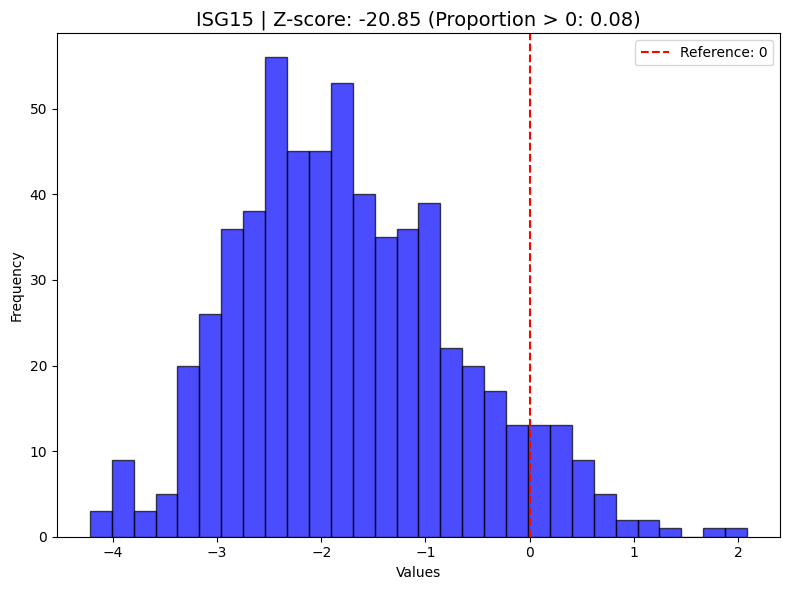

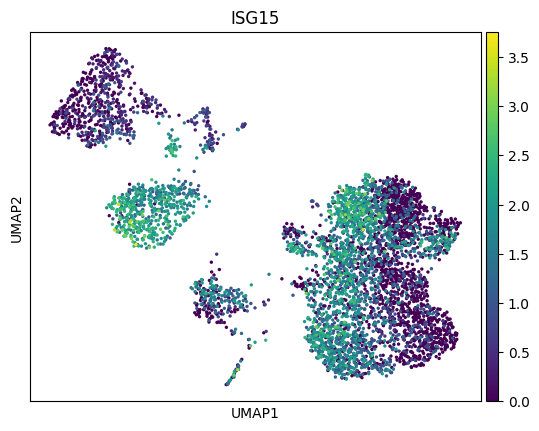

Plotting: SERPING1
adjusted p-value: 0.0


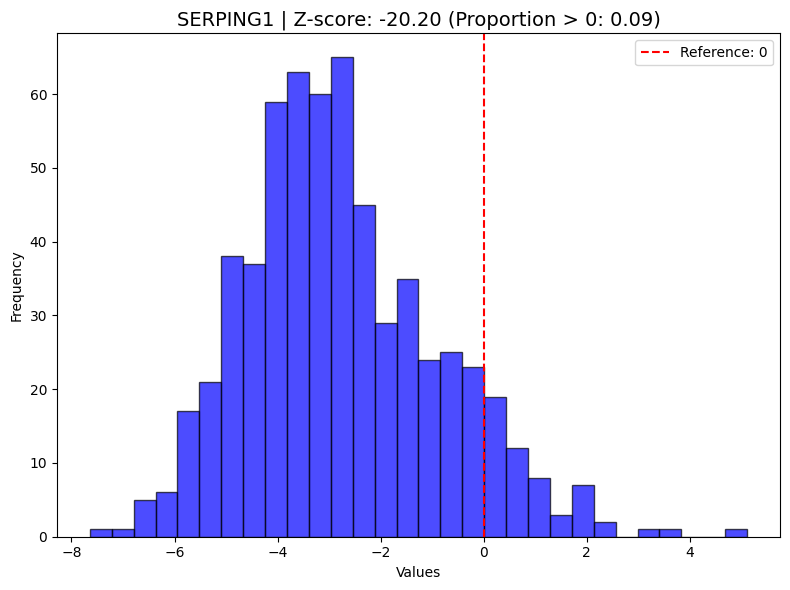

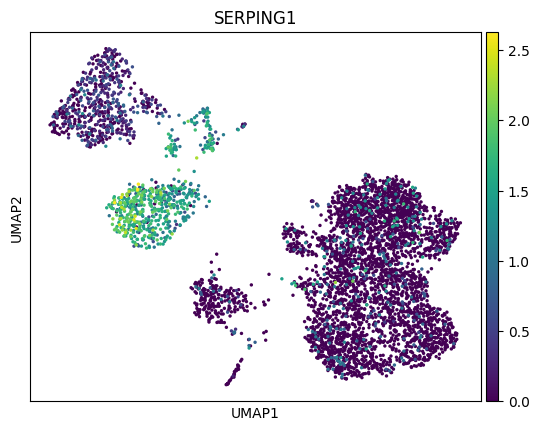

Plotting: MX1
adjusted p-value: 0.0


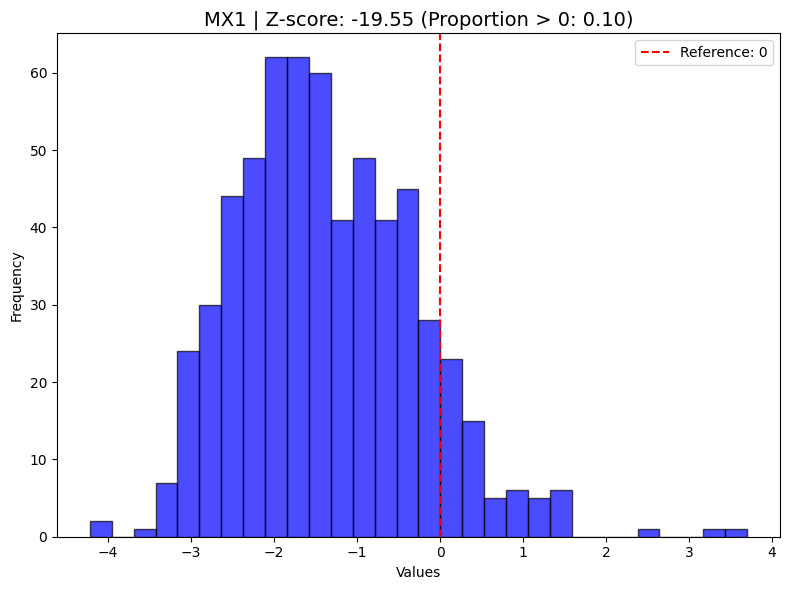

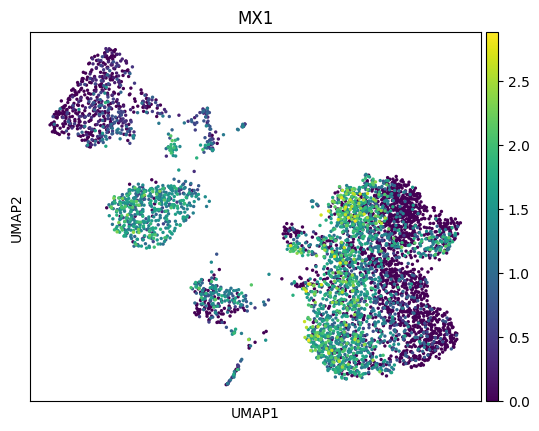

Plotting: TNFSF10
adjusted p-value: 0.0


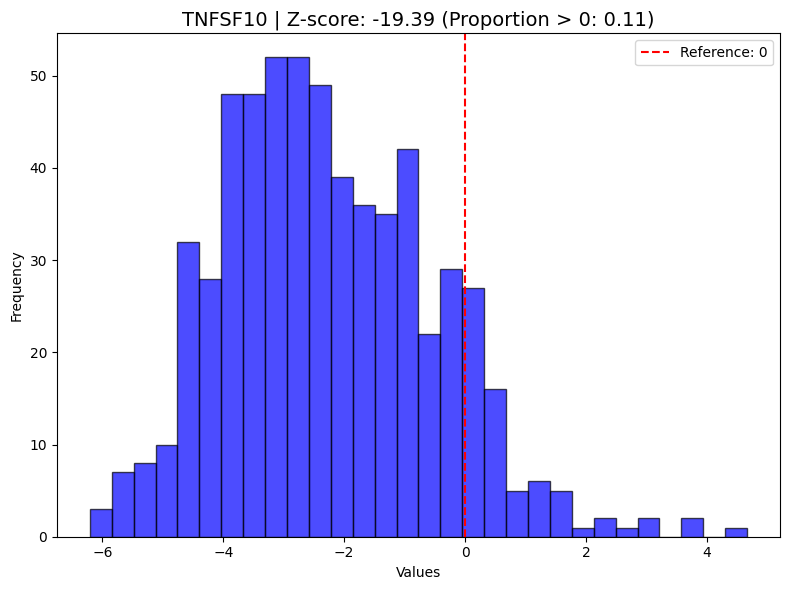

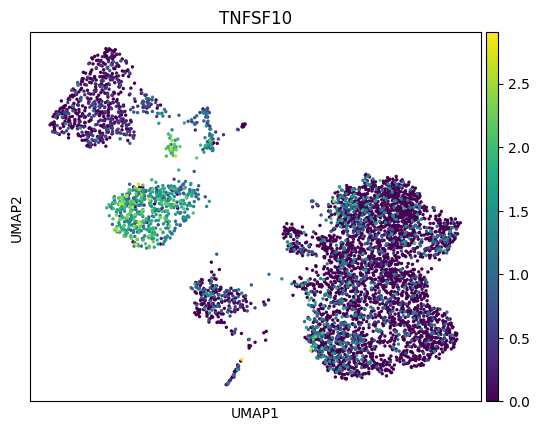

Plotting: OAS1
adjusted p-value: 0.0


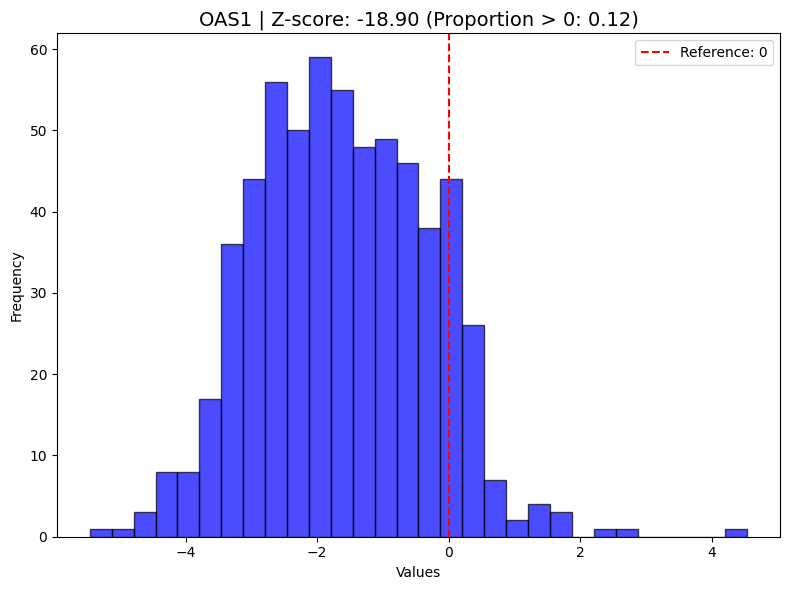

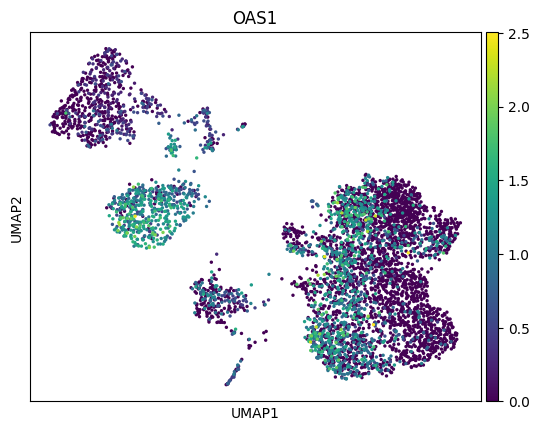

Number of genes with ITE adjusted p-values less than 0.01 349
Selected most significant genes:
       Gene    Z score  Adjusted_p
0     ISG15 -39.730468         0.0
1  SERPING1 -36.412026         0.0
2   TNFSF10 -32.111087         0.0
3       MX1 -31.072775         0.0
4     RSAD2 -30.678722         0.0
Plotting: ISG15
adjusted p-value: 0.0


<Figure size 1000x600 with 0 Axes>

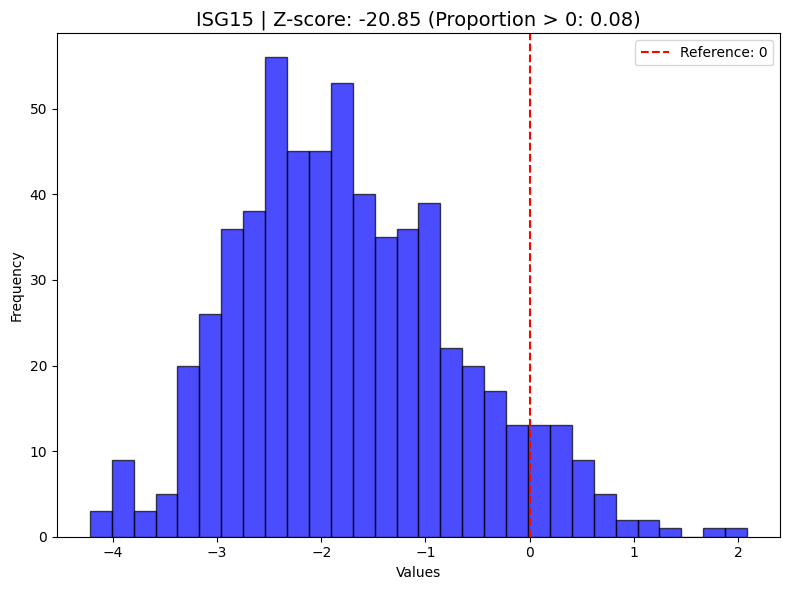

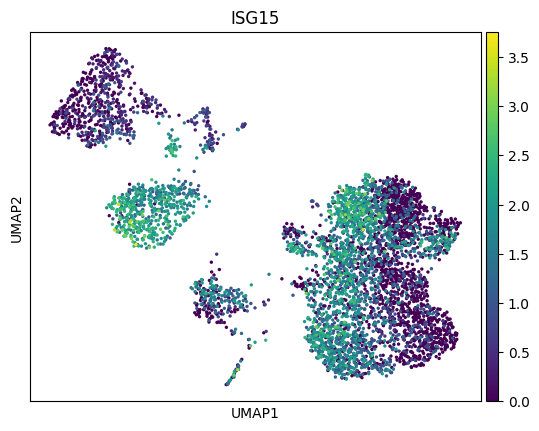

Plotting: SERPING1
adjusted p-value: 0.0


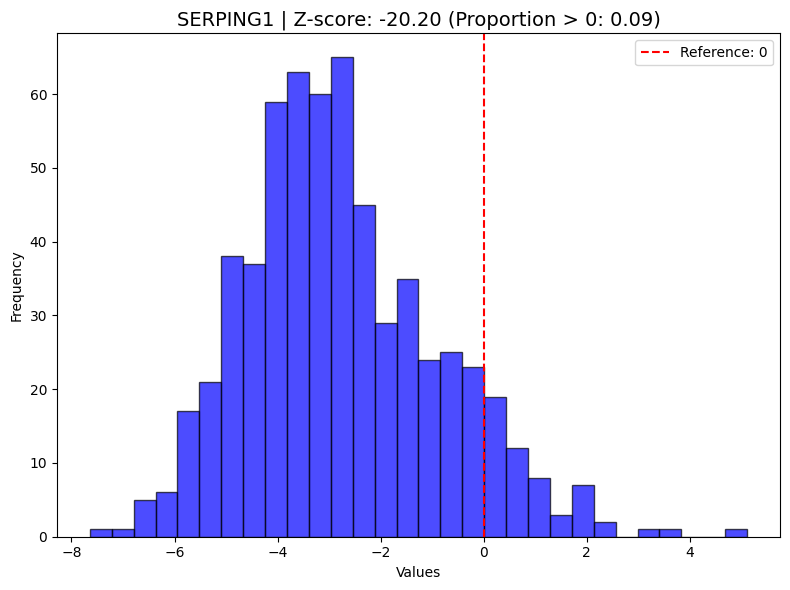

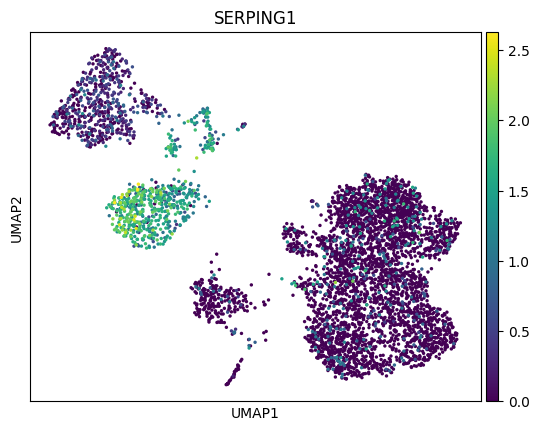

Plotting: TNFSF10
adjusted p-value: 0.0


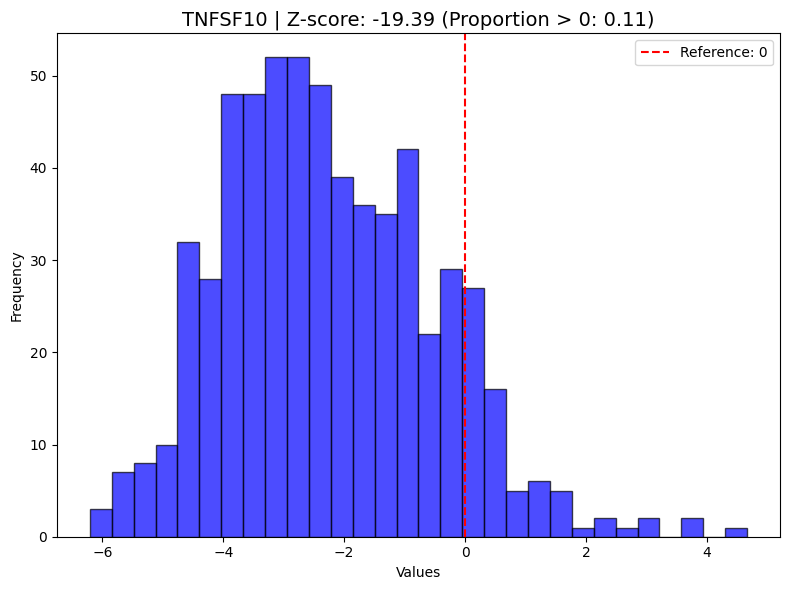

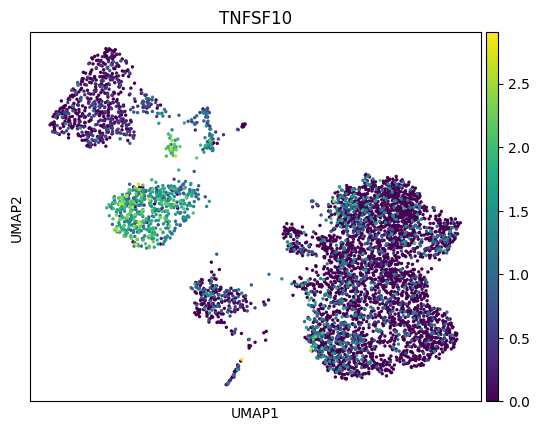

Plotting: MX1
adjusted p-value: 0.0


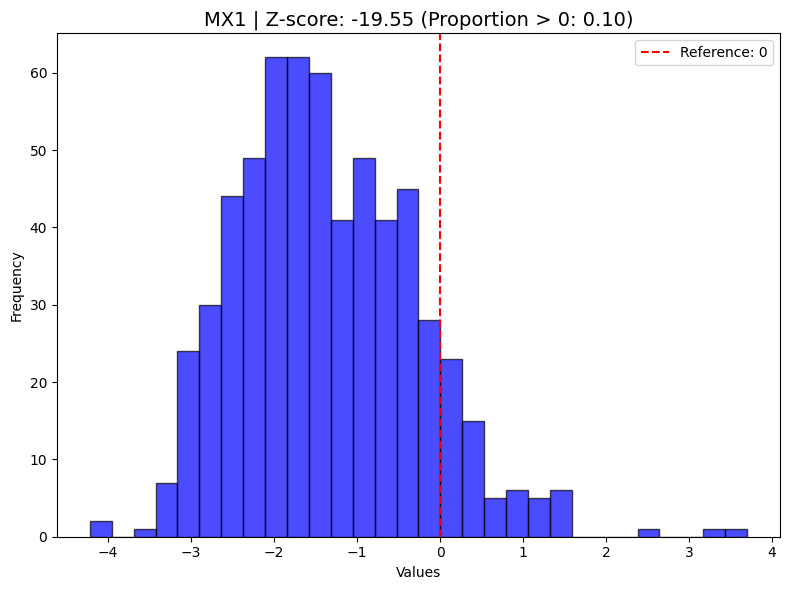

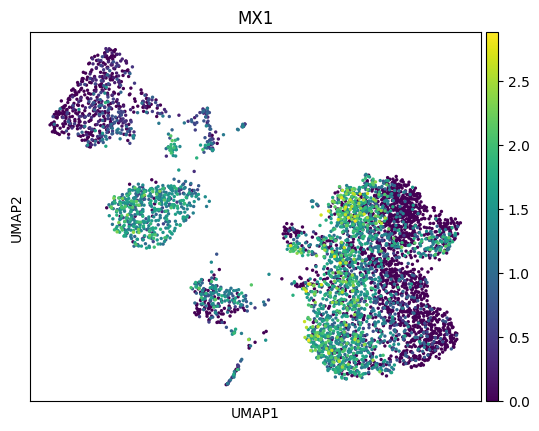

Plotting: RSAD2
adjusted p-value: 0.0


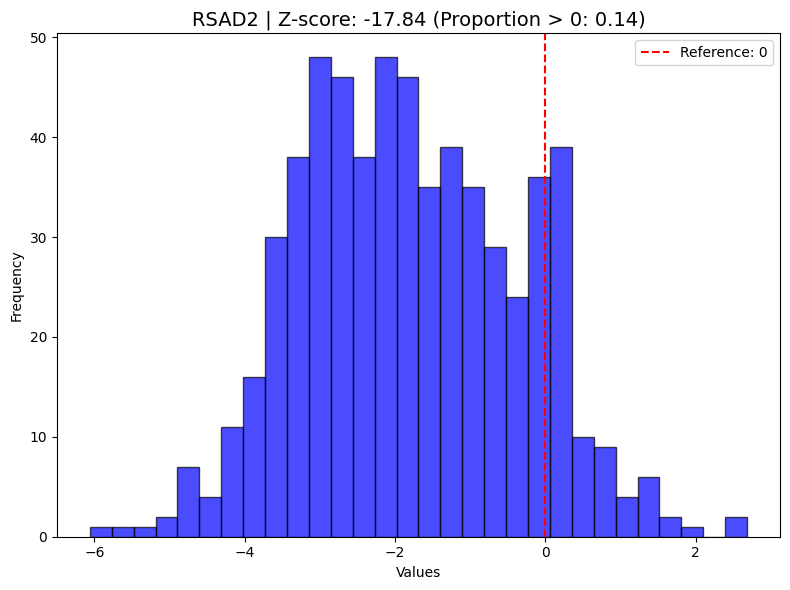

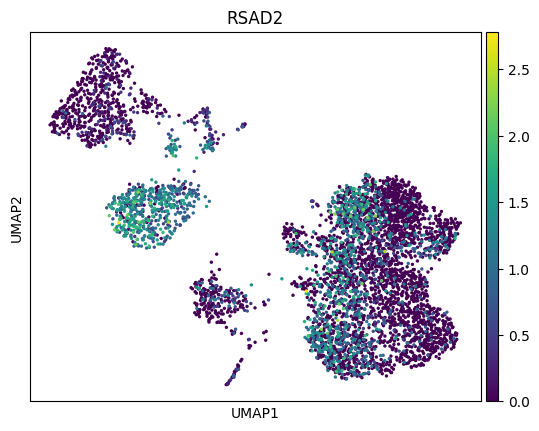

array([ 1.59480212e+00,  8.44212359e-01, -1.94163719e+00, -1.21133313e+00,
        4.24493060e+00,  5.85191465e-01,  1.29461332e+00,  3.54120293e+00,
        1.15059187e+00,  6.86974550e-01,  2.05416103e+00,  2.27368025e-01,
       -4.23419001e+00, -4.26057284e+00,  1.12019507e+00,  1.17118380e+00,
        5.42083111e-02,  2.32452386e+00, -5.99013168e+00,  6.79972103e-01,
        1.65556989e+01,  5.91645242e+00,  1.88791583e-01,  3.03895553e-01,
        1.78358673e+00, -5.79578991e+00, -1.25209207e+00,  3.87326473e+00,
       -1.43186696e+01, -4.13663494e+00, -4.50262356e+00, -4.66238187e+00,
       -6.80213973e-01,  4.10123133e+00,  7.27029861e+00, -2.76626170e+01,
       -4.55760693e+00,  1.55557527e+01,  1.18063878e+01,  1.92486379e+00,
        1.17771833e+00,  2.56130755e+00,  7.07867934e-01, -1.02691075e+01,
        1.87868679e+00,  1.90585057e-01, -1.70521770e+00, -1.23040219e-01,
       -1.01957111e+01,  1.00707528e+01,  2.01852334e+00, -1.71453063e+00,
       -1.26452717e+00,  

In [11]:
adata=sc.read_h5ad("./PBMC_yale/b-0--c-1__ITE.h5ad")
indices=adata.obs["cell_type0528"]=="Monocyte"
Plot_and_Estimate_CATE_adata(adata,indices)
print("="*20)
Plot_and_Estimate_CATE_adata(adata,indices,parametric=True)

# For CINEMA-OT

In [12]:
import numpy as np
import scanpy as sc
import cinemaot as co
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import random
import torch
import sklearn
import os
def set_seed(seed: int):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If using multi-GPU.

        # Ensure deterministic behavior in PyTorch (can slow down computations)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Set sklearn random seed
    sklearn.utils.check_random_state(seed)

    # Set environment variable for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(123)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

In [13]:
def run_cinema_ot(adata, condition_key, cell_type_key,exp_label,ref_label, dataset_name):
    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    print(adata)
    if adata.shape[1]>2000:
        sc.pp.highly_variable_genes(adata, n_top_genes=2000)
        adata = adata[:, adata.var["highly_variable"]]
    
    adata_=adata.copy()
    print(adata_)
    sc.pp.pca(adata_)
    print(condition_key,ref_label,exp_label,cell_type_key)
    cf, ot, de = co.cinemaot.cinemaot_unweighted(adata_, obs_label=condition_key, ref_label=ref_label,
                                                 expr_label=exp_label, mode='parametric', thres=0.5,
                                                 smoothness=1e-5, eps=1e-3, preweight_label=cell_type_key)
    adata_.obsm['cf'] = cf.copy()
    adata_.obsm['cf'][adata_.obs[condition_key]==ref_label,:] = np.matmul(ot/np.sum(ot,axis=1)[:,None],cf[adata_.obs[condition_key]==exp_label,:])
    sc.pp.neighbors(adata_, use_rep='cf')

    sc.tl.umap(adata_, random_state=1)
    print("Effect modifier (called confounder in this paper) space:")
    sc.pl.umap(adata_, color=[condition_key, cell_type_key], wspace=0.5)
    
    return de

AnnData object with n_obs × n_vars = 5027 × 773
    obs: 'perturbation', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'leiden', 'cell_type0528'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type0528_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 5027 × 773
    obs: 'perturbation', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'leiden', 'cell_type0528'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type0528_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'dis

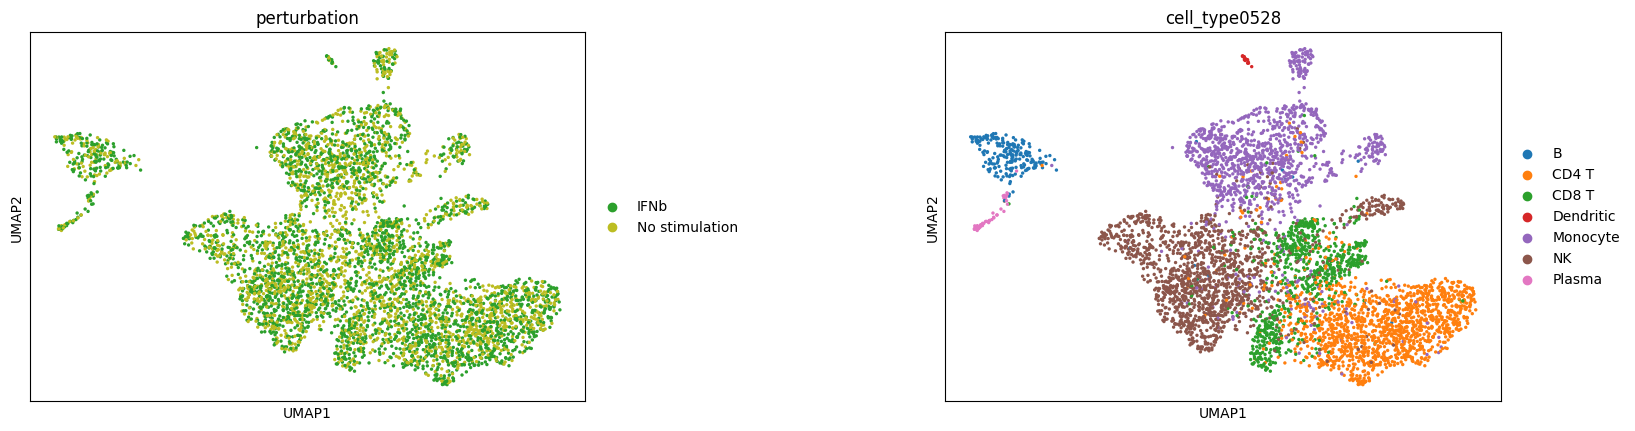

In [14]:
adata = sc.read_h5ad('../data/PBMC_yale_preprocessed.h5ad')

ITE1=run_cinema_ot(adata=adata, condition_key='perturbation', cell_type_key='cell_type0528', exp_label='IFNb', ref_label='No stimulation', dataset_name="PBMC_yale")

Number of genes with ITE adjusted p-values less than 0.01 641
Selected most significant genes:
     Gene    Z score  Adjusted_p
0  IFITM1 -23.149952         0.0
1   ISG15 -22.823896         0.0
2    LY6E -22.660868         0.0
3   IFIT1 -22.253299         0.0
4    IFI6 -22.171785         0.0
Plotting: IFITM1
adjusted p-value: 0.0


<Figure size 1000x600 with 0 Axes>

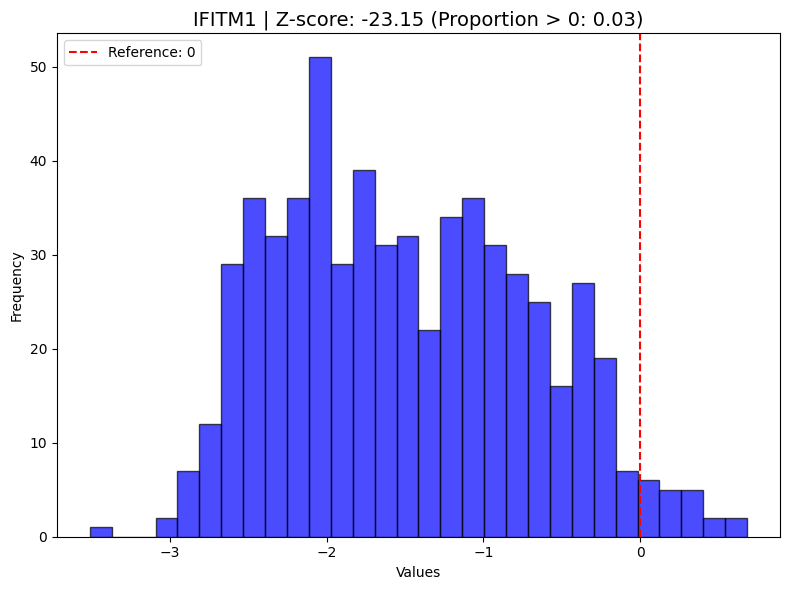

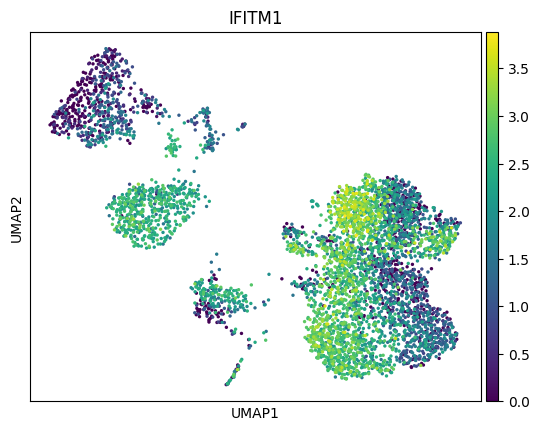

Plotting: ISG15
adjusted p-value: 0.0


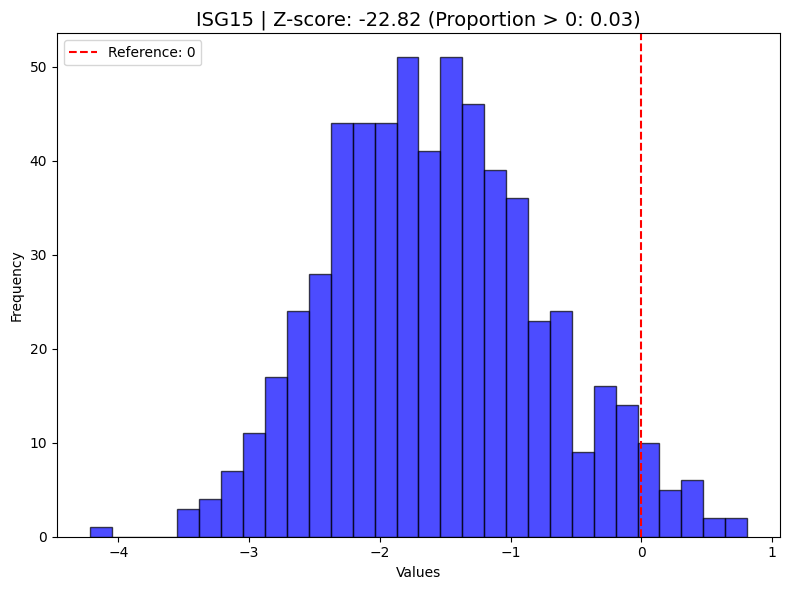

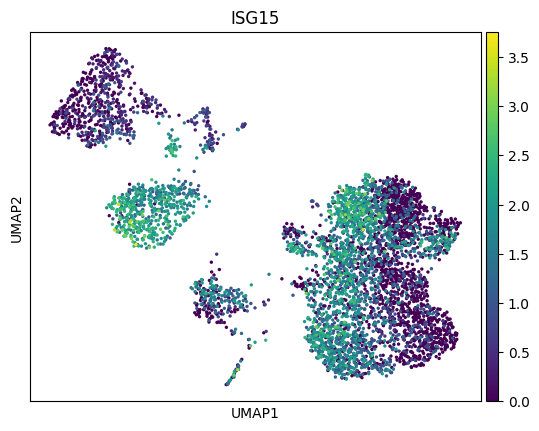

Plotting: LY6E
adjusted p-value: 0.0


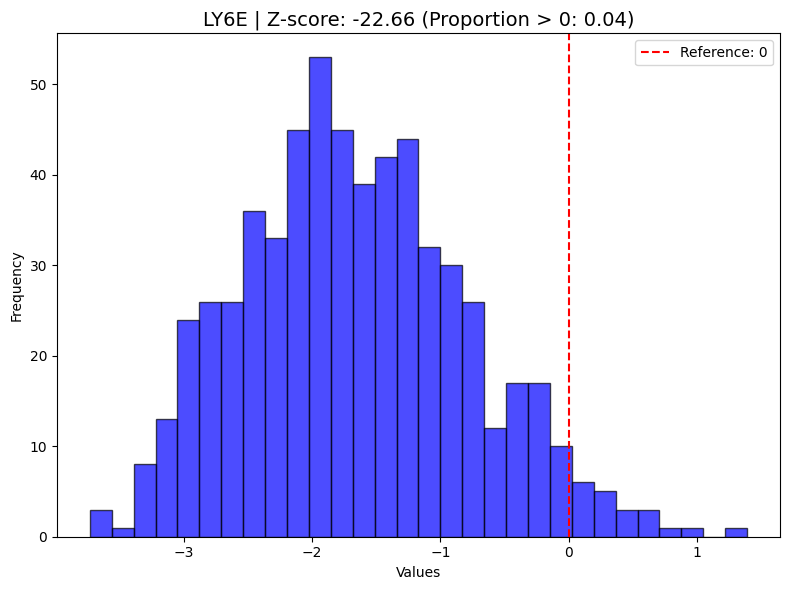

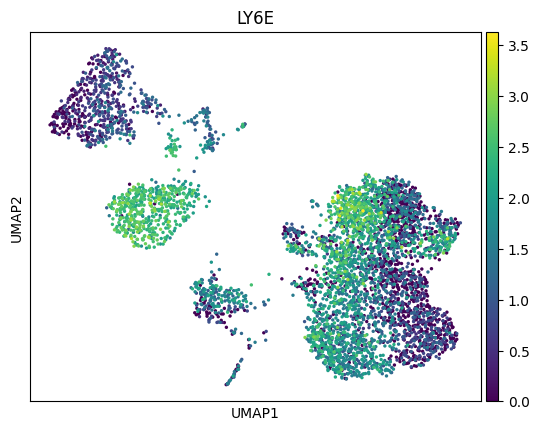

Plotting: IFIT1
adjusted p-value: 0.0


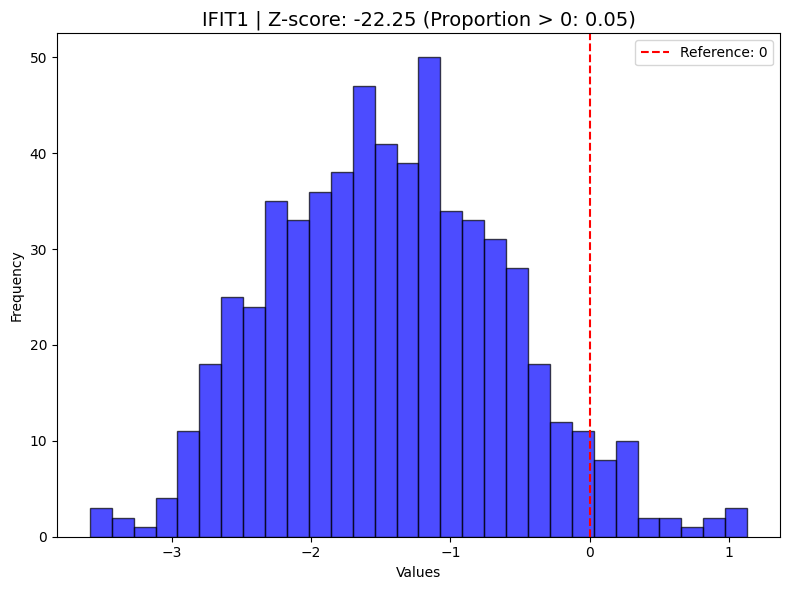

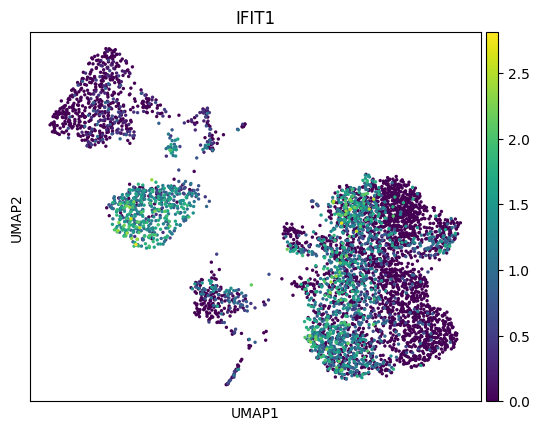

Plotting: IFI6
adjusted p-value: 0.0


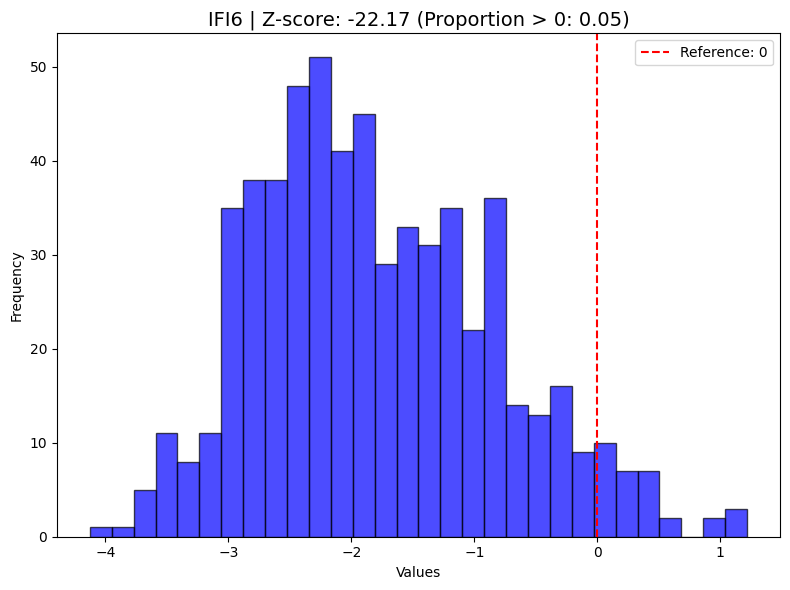

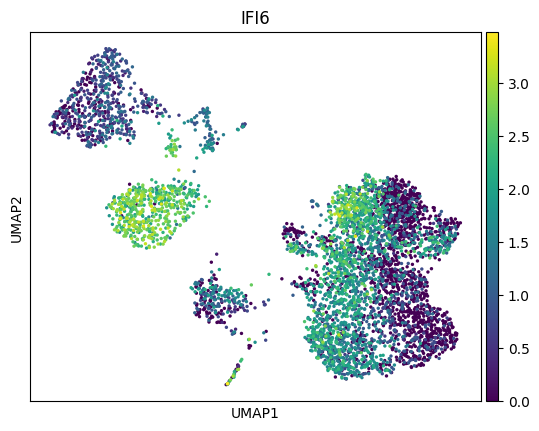

Number of genes with ITE adjusted p-values less than 0.01 394
Selected most significant genes:
     Gene    Z score  Adjusted_p
0   ISG15 -47.096526         0.0
1    LY6E -46.687922         0.0
2  IFITM1 -46.101115         0.0
3    IFI6 -45.653577         0.0
4   IFIT1 -42.364638         0.0
Plotting: ISG15
adjusted p-value: 0.0


<Figure size 1000x600 with 0 Axes>

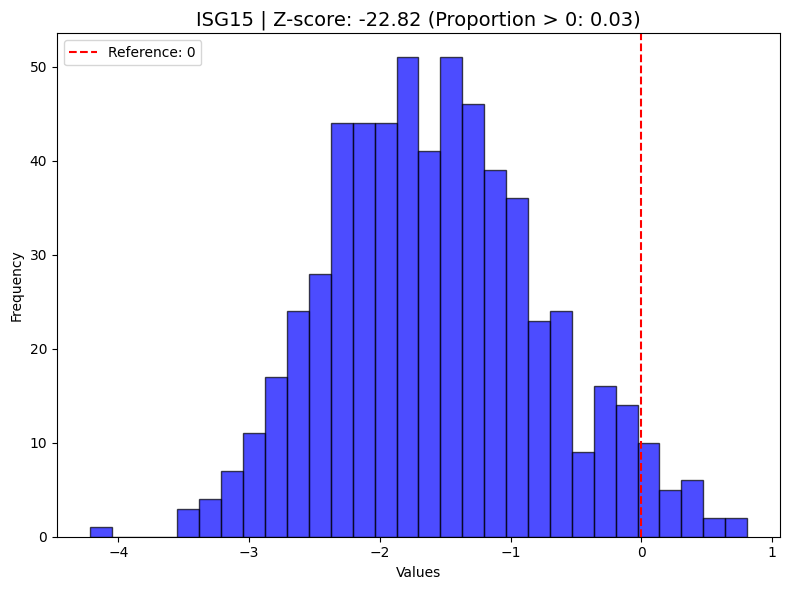

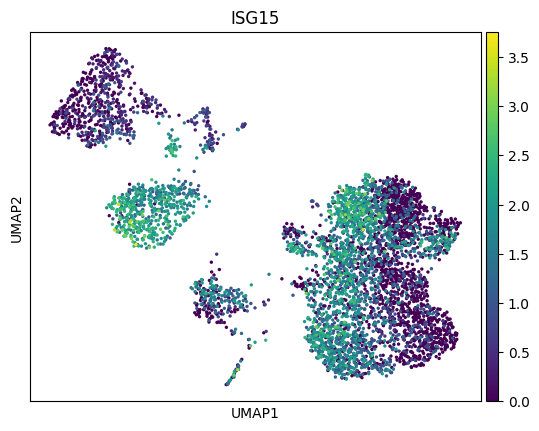

Plotting: LY6E
adjusted p-value: 0.0


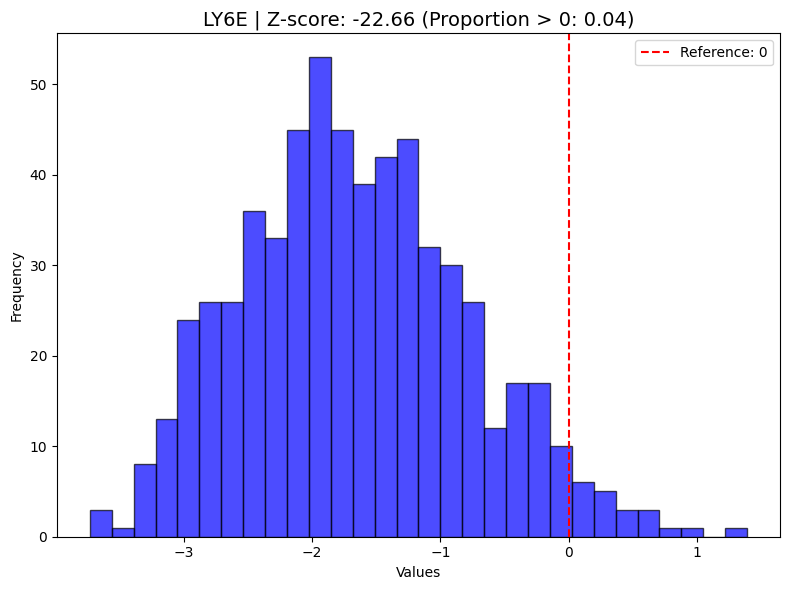

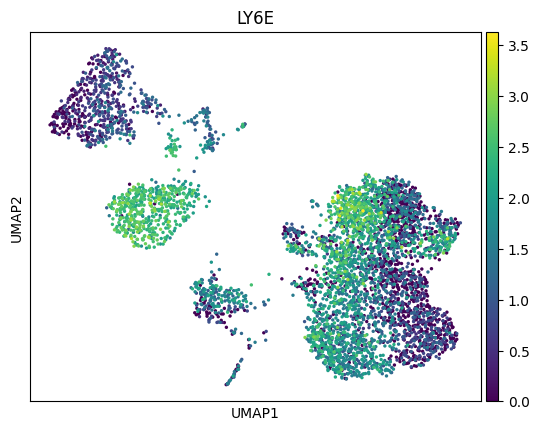

Plotting: IFITM1
adjusted p-value: 0.0


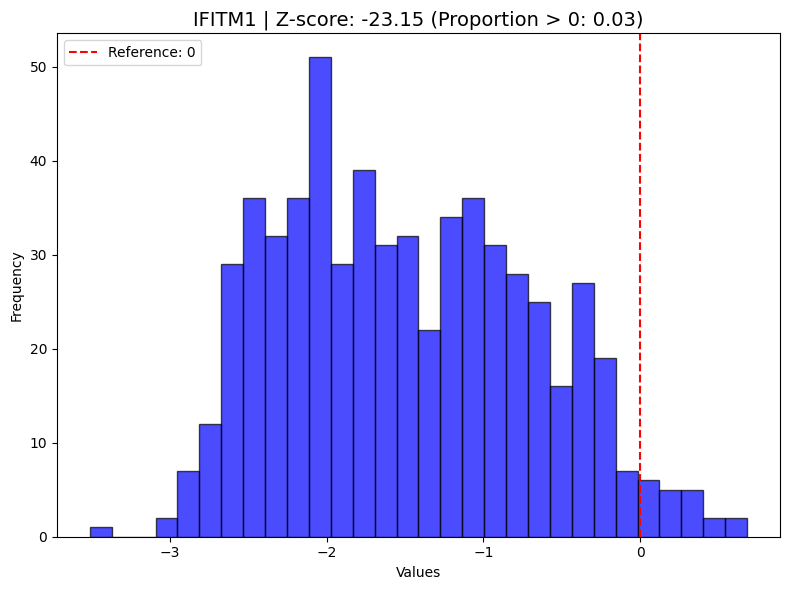

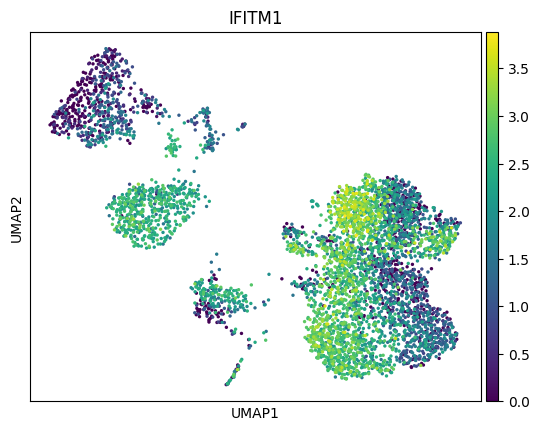

Plotting: IFI6
adjusted p-value: 0.0


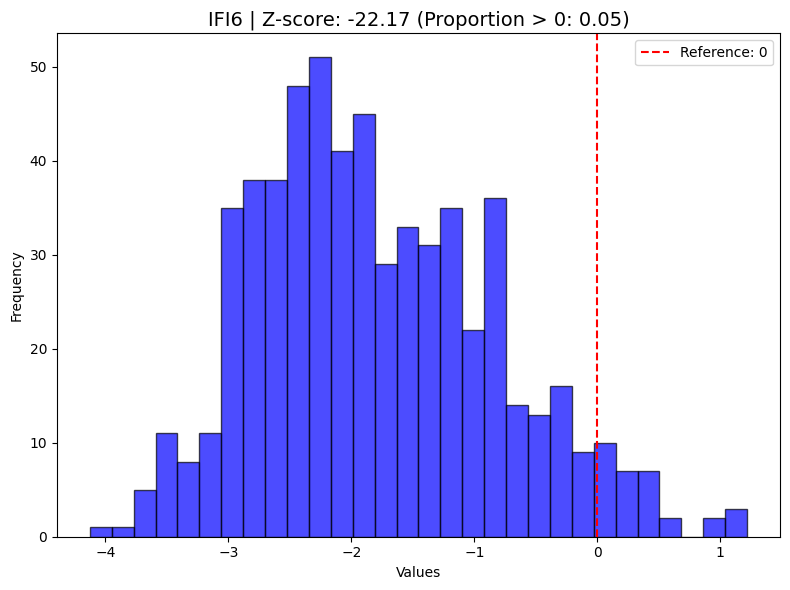

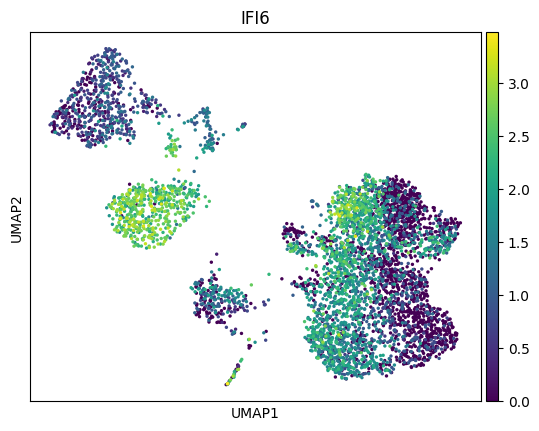

Plotting: IFIT1
adjusted p-value: 0.0


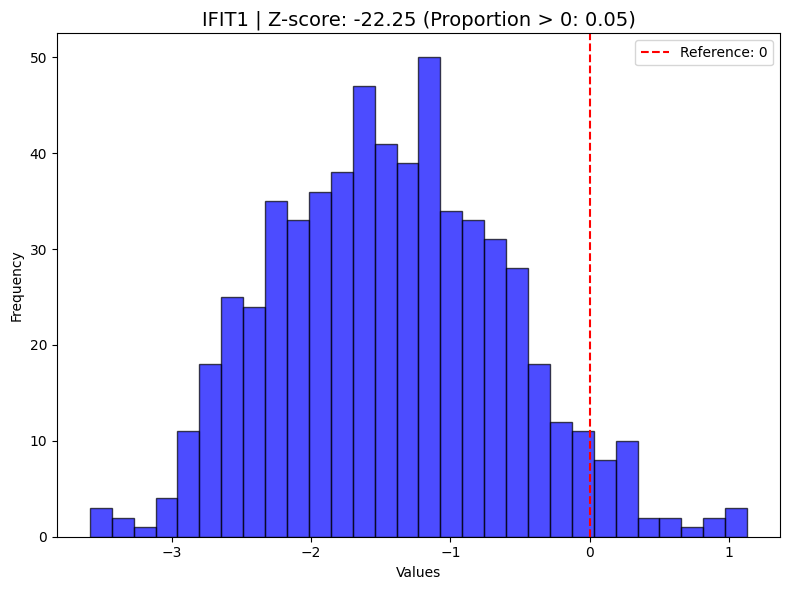

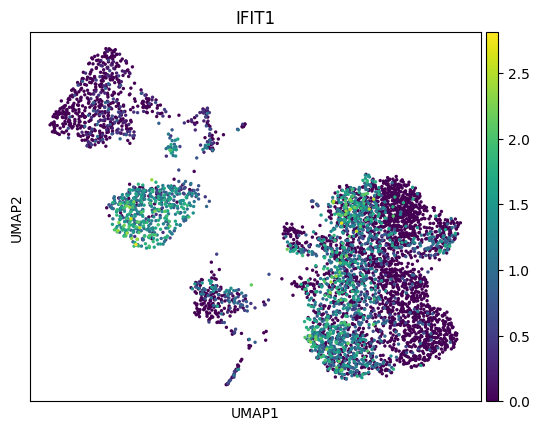

array([ 1.56565138e+00,  6.67395406e-01, -6.24273518e-01,  1.21607198e+00,
       -2.68050571e-01,  5.09912462e+00, -2.17655666e-01,  3.54277356e+00,
        4.29854205e+00,  1.00266583e+00,  3.05199977e+00,  2.43117674e+01,
        4.60557293e+00, -4.25330121e-01, -4.23323618e-01, -3.28830121e+00,
       -4.02185711e+00,  5.08694544e+00,  1.52400757e+00,  3.59073632e+00,
        3.10022419e+00, -5.70762730e-01, -3.19260725e+00,  9.76873521e-01,
        1.64381604e+01,  4.56329300e+00,  5.71350750e-01,  1.82004717e-01,
        1.12088440e+00, -3.73424163e+00, -1.83590646e-01, -2.06481862e+00,
       -1.85575862e+01, -3.15483392e+00, -2.10582014e-01, -1.93708539e+00,
        1.92374483e+00,  2.65996027e+00,  7.62896536e+00, -2.89398771e+01,
       -4.44779255e+00,  1.75540710e+01,  1.38941826e+01,  5.24513279e-01,
       -1.15751753e+00,  4.61193645e+00,  2.03362425e+00, -1.01422023e+01,
        1.99005153e+00, -4.29705647e-01, -3.23887375e+00,  2.68241459e-02,
       -1.00550112e+01,  

In [15]:
indices=ITE1.obs["cell_type0528"]=="Monocyte"
Plot_and_Estimate_CATE_adata(ITE1,indices)
print("="*20)
Plot_and_Estimate_CATE_adata(ITE1,indices,parametric=True)